<a href="https://colab.research.google.com/github/Ayamokht/DL-NLP-Project/blob/main/Product_Classification_Project_Aya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import re
import pandas as pd
import numpy as np
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy

from collections import Counter
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm import tqdm
from tqdm.notebook import tqdm

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
X_test = pd.read_csv("/content/drive/MyDrive/NLP_DL_Project/X_test_update.csv")
X_train = pd.read_csv("/content/drive/MyDrive/NLP_DL_Project/X_train_update.csv")
Y_train = pd.read_csv("/content/drive/MyDrive/NLP_DL_Project/Y_train_CVw08PX.csv")

In [46]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   84916 non-null  int64 
 1   designation  84916 non-null  object
 2   description  55116 non-null  object
 3   productid    84916 non-null  int64 
 4   imageid      84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.2+ MB


In [47]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13812 entries, 0 to 13811
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   13812 non-null  int64 
 1   designation  13812 non-null  object
 2   description  8926 non-null   object
 3   productid    13812 non-null  int64 
 4   imageid      13812 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 539.7+ KB


In [48]:
Y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Unnamed: 0   84916 non-null  int64
 1   prdtypecode  84916 non-null  int64
dtypes: int64(2)
memory usage: 1.3 MB


In [49]:
# Supprimer la colonne inutile
X_train.drop(columns=["Unnamed: 0"], inplace=True)
X_test.drop(columns=["Unnamed: 0"], inplace=True)
Y_train.drop(columns=["Unnamed: 0"], inplace=True)

### Analyse de la target (prdtypecode)

In [50]:
# nombre de modalités uniques
nb_modalite_prdt = Y_train["prdtypecode"].nunique()
print(f"Nombre total de catégories de produits : {nb_modalite_prdt}")

Nombre total de catégories de produits : 27


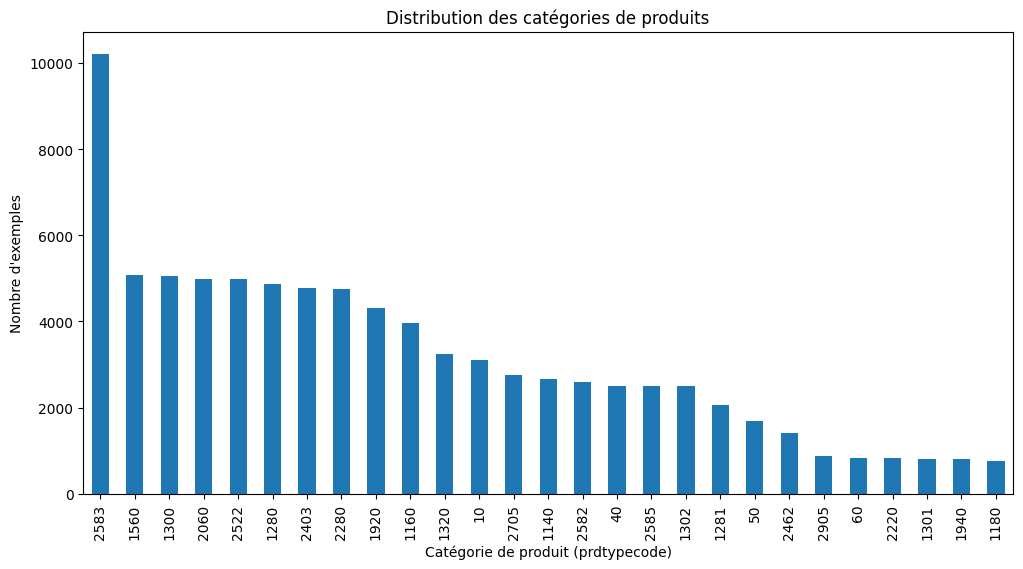

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
Y_train["prdtypecode"].value_counts().plot(kind="bar")
plt.xlabel("Catégorie de produit (prdtypecode)")
plt.ylabel("Nombre d'exemples")
plt.title("Distribution des catégories de produits")
plt.xticks(rotation=90)
plt.show()

### Analyse des variables explicatives

In [52]:
# check données manquantes
missing_description = X_train["description"].isnull().sum()
missing_percentage = (missing_description / len(X_train)) * 100
print(f"Pourcentage de données manquantes dans la colonne 'description' : {missing_percentage:.2f}%")

Pourcentage de données manquantes dans la colonne 'description' : 35.09%


In [53]:
X_train.isna().sum()

,0
designation,0
description,29800
productid,0
imageid,0


### Preprocessing

In [54]:
#!pip install nltk tqdm spacy

In [55]:
#!python -m spacy download fr_core_news_sm

In [56]:
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

# listes des stopwords
stop_words = set(stopwords.words('french'))
custom_stopwords = set(["x", "cm", "pouvoir", "être", "permettre", "avoir", "faire", "nouveau", "différent"]) # rajoutés à la main a laide du wordcloud
stop_words.update(custom_stopwords)

nlp = spacy.load('fr_core_news_sm')

# Fonction de nettoyage de texte
def clean_text(text):
    # si la colonne est une valeur NaN on la remplace avec une chaine vide ""
    if pd.isnull(text):
        return ""

    # Conversion en minuscules
    text = text.lower()

    # Supprimer les nombres
    text = re.sub(r'\d+', '', text)

    # Supprimer la ponctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Utiliser spaCy pour la lemmatisation
    doc = nlp(text)
    words = [token.lemma_ for token in doc if token.text.strip() and token.text.lower() not in stop_words]

    return " ".join(words)

In [57]:
tqdm.pandas(desc="Preprocessing texts")

# Appliquer le prétraitement sur X_train
print("Prétraitement de X_train...")
X_train["designation_clean"] = X_train["designation"].progress_apply(clean_text)
X_train["description_clean"] = X_train["description"].progress_apply(clean_text)

# Appliquer le prétraitement sur X_test
print("Prétraitement de X_test...")
X_test["designation_clean"] = X_test["designation"].progress_apply(clean_text)
X_test["description_clean"] = X_test["description"].progress_apply(clean_text)

# Afficher les résultats pour vérification
print("\nExemples des données prétraitées (X_train) :")
X_train[["designation", "designation_clean", "description", "description_clean"]].head()

Prétraitement de X_train...


Preprocessing texts:   0%|          | 0/84916 [00:00<?, ?it/s]

Preprocessing texts:   0%|          | 0/84916 [00:00<?, ?it/s]

Prétraitement de X_test...


Preprocessing texts:   0%|          | 0/13812 [00:00<?, ?it/s]

Preprocessing texts:   0%|          | 0/13812 [00:00<?, ?it/s]


Exemples des données prétraitées (X_train) :


,designation,designation_clean,description,description_clean
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,olivier personalisierte notizbuch seiten punkt...,NaN,
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,journal art lart marche salon dart asiatique a...,NaN,
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,grand stylet ergonomique bleu gamepad nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,pilot style touch pen marque speedlink stylet ...
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,peluche donald europe disneyland marionnette d...,NaN,
4,La Guerre Des Tuques,guerre tuque,Luc a des id&eacute;es de grandeur. Il veut or...,luc avoir ideacutee grandeur vouloir organiser...


In [58]:
# freq des mots les plus courants dans les deux col textuelles
def get_most_common_words(series, top_n=20):
    words = Counter(" ".join(series.dropna()).split())
    return words.most_common(top_n)

common_words_designation = get_most_common_words(X_train["designation_clean"])
common_words_description = get_most_common_words(X_train["description_clean"])

In [59]:
common_words_designation

[('jeu', 5776),
 ('piscine', 4809),
 ('lot', 4357),
 ('avoir', 3850),
 ('coussin', 3608),
 ('enfant', 2977),
 ('kit', 2684),
 ('blanc', 2667),
 ('jouet', 2531),
 ('taie', 2493),
 ('pc', 2379),
 ('rc', 2364),
 ('led', 2211),
 ('noir', 2120),
 ('sac', 2025),
 ('the', 2006),
 ('carte', 2006),
 ('décor', 1960),
 ('décoration', 1893),
 ('bleu', 1877)]

In [60]:
common_words_description

[('br', 44410),
 ('pouvoir', 36400),
 ('couleur', 27840),
 ('taille', 25030),
 ('tout', 24943),
 ('plus', 21748),
 ('piscine', 19750),
 ('avoir', 19746),
 ('haute', 18077),
 ('p', 16239),
 ('qualité', 16231),
 ('produit', 13751),
 ('facile', 13494),
 ('utiliser', 13239),
 ('matériel', 12786),
 ('dimension', 12681),
 ('the', 12462),
 ('enfant', 12117),
 ('millimètre', 11383),
 ('and', 11329)]

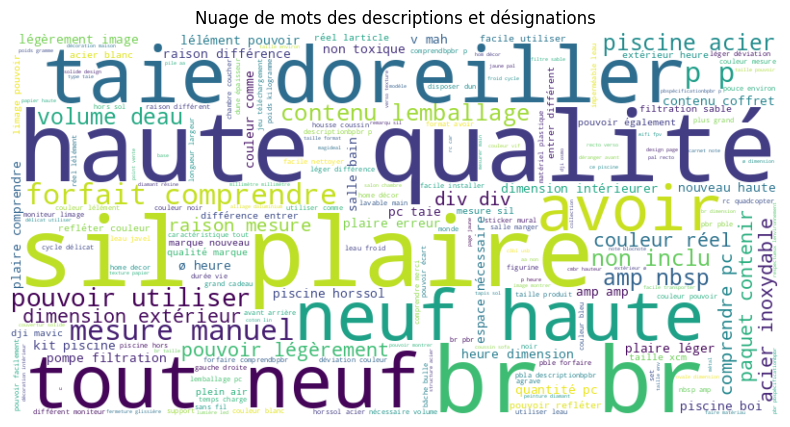

In [61]:
# nuage de mots
text_combined = " ".join(X_train["designation_clean"].dropna().astype(str)) + " " + " ".join(X_train["description_clean"].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_combined)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots des descriptions et désignations")
plt.show()

In [62]:
X_test

,designation,description,productid,imageid,designation_clean,description_clean
0,Folkmanis Puppets - 2732 - Marionnette Et Théâ...,NaN,516376098,1019294171,folkmani puppet marionnette théâtre mini turtle,
1,Porte Flamme Gaxix - Flamebringer Gaxix - 136/...,NaN,133389013,1274228667,porte flamme gaxix flamebringer gaxix u twilig...,
2,Pompe de filtration Speck Badu 95,NaN,4128438366,1295960357,pompe filtration speck badu,
3,Robot de piscine électrique,<p>Ce robot de piscine d&#39;un design innovan...,3929899732,1265224052,robot piscine électrique,pce robot piscine dun design innover élégant a...
4,Hsm Destructeur Securio C16 Coupe Crois¿E: 4 X...,NaN,152993898,940543690,hsm destructeur securio coupe croise millimètre,
...,...,...,...,...,...,...
13807,Robe De Soutien De Sac De Soins De Les Suspend...,Robe Porte-soins Sac Protecteur vêtements Hang...,3959381879,1269508019,rob soutien sac soin suspendre vêtement protec...,rob portesoin sac protecteur vêtement hanging ...
13808,Livre De Phrases - Français ? Thaïlandais,NaN,1546314127,1308816290,livre phrase français thaïlandais,
13809,Tifon1 200 M de Espa - Pompe piscine,Tension (V) : Monophasé - 230 V Puissance : 2...,2887191300,1169904062,tifon espa pompe piscin,tension v monophasé v puissance cv type pompe ...
13810,Christmas Home Non Slip Door Floor Mats Hall R...,Christmas Home Non Slip Door Floor Mats Hall R...,4061586053,1283583872,christma home non slip door floor mat hall rug...,christma home non slip door floor mat hall rug...


In [63]:
# Combiner 'designation' et 'description' en une seule colonne
X_train["text_clean"] = X_train["designation_clean"] + " " + X_train["description_clean"]
X_test["text_clean"] = X_test["designation_clean"] + " " + X_test["description_clean"]

In [64]:
X_train

,designation,description,productid,imageid,designation_clean,description_clean,text_clean
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,olivier personalisierte notizbuch seiten punkt...,,olivier personalisierte notizbuch seiten punkt...
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,journal art lart marche salon dart asiatique a...,,journal art lart marche salon dart asiatique a...
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,grand stylet ergonomique bleu gamepad nintendo...,pilot style touch pen marque speedlink stylet ...,grand stylet ergonomique bleu gamepad nintendo...
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,peluche donald europe disneyland marionnette d...,,peluche donald europe disneyland marionnette d...
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,guerre tuque,luc avoir ideacutee grandeur vouloir organiser...,guerre tuque luc avoir ideacutee grandeur voul...
...,...,...,...,...,...,...,...
84911,The Sims [ Import Anglais ],NaN,206719094,941495734,the sims import anglais,,the sims import anglais
84912,Kit piscine acier NEVADA déco pierre Ø 3.50m x...,<b>Description complète :</b><br />Kit piscine...,3065095706,1188462883,kit piscine acier nevada déco pierre ø,bdescription complet bbr kit piscine horssol p...,kit piscine acier nevada déco pierre ø bdescri...
84913,Journal Officiel De La Republique Francaise N°...,NaN,440707564,1009325617,journal officiel republique francais changemen...,,journal officiel republique francais changemen...
84914,Table Basse Bois De Récupération Massif Base B...,<p>Cette table basse a un design unique et con...,3942400296,1267353403,table bas bois récupération massif base blanc ...,pcette table bas avoir design unique constitue...,table bas bois récupération massif base blanc ...
